<font size="5">ライブラリのインポート

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt
import random
import math
import pandas as pd
import csv

<font size="5">cpuとgpuの選択

In [2]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "gpu")

<font size="5">乱数を特定の値にして再現性を確保

In [3]:
# For reproducibility
torch.manual_seed(42)
if use_cuda:
    torch.cuda.manual_seed(42)

<font size ="5">pytorch用データセットの作成

In [4]:
# Load MNIST dataset
# pytorchではTensorというデータ構造で、モデルの入力、出力、パラメータを表現
# 前処理の定義
"""
これから取得するDatasetの中身がndarray型のデータ集合であるため、前処理でtensor型にしたい

root
Datasetを参照(または保存)するディレクトリを「path」の部分に指定する.
そのディレクトリに取得したいDatasetが存在すればダウンロードせずにそれを使用する.

train
Training用のdataを取得するかどうかを選択する.
FalseにすればTest用のdataを取得するが,この2つの違いはdata数の違いと思ってくれて良い.

download
rootで参照したディレクトリにDatasetがない場合ダウンロードするかどうかを決めることができる.

transform
定義した前処理を渡す.
こうすることでDataset内のdataを参照する時にその前処理を自動で行ってくれる.
"""
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# 学習用データとテスト用データの取得
# transformは私用すると前処理を指定できる
# これによりdatasetをdetaloaderに渡して使える状態にした
train_dataset_original = datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
print(f"Train Dataset Size: {len(train_dataset_original)}")
test_dataset_original = datasets.FashionMNIST(root='./data', train=False, transform=transform)
print(f"Test Dataset Size: {len(test_dataset_original)}")

Train Dataset Size: 60000
Test Dataset Size: 10000


C:\Users\y9723\anaconda3\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


<font size ="5">データの個数を調節

In [5]:
# traindata
# クラス数を取得
num_classes = len(train_dataset_original.classes)
print(num_classes)
print(len(train_dataset_original))
# 各クラスごとのデータ数を計算
desired_class_count = 3000  # 各クラスごとに均等に分割したいデータ数
total_desired_count = desired_class_count * num_classes

# クラスごとに均等にデータを分割するためのリストを作成
selected_indices_1 = []
selected_indices_2 = []

# 各クラスごとに均等にデータを選択
for class_idx in range(num_classes):
    class_indices = np.where(train_dataset_original.targets == class_idx)[0]
    np.random.shuffle(class_indices)
    selected_indices_1.extend(class_indices[:desired_class_count])
    selected_indices_2.extend(class_indices[desired_class_count:2*desired_class_count])

# 選択したデータで新しいデータセットを作成
train_data_1 = torch.utils.data.Subset(train_dataset_original, selected_indices_1)
train_data_2 = torch.utils.data.Subset(train_dataset_original, selected_indices_2)

# # 各クラスごとの新しいデータ数を確認
class_counts_subset_1 = np.bincount([train_dataset_original.targets[i] for i in selected_indices_1])
class_counts_subset_2 = np.bincount([train_dataset_original.targets[i] for i in selected_indices_2])

print("データセット1の各クラスごとの新しいデータ数:", class_counts_subset_1)
print("データセット2の各クラスごとの新しいデータ数:", class_counts_subset_2)

# testdata
# 2. データセット内のクラスごとのサンプル数を確認
class_count = [0] * 10# 10はFashionMNISTのクラス数です
sample_indices = []
for i in range(len(test_dataset_original)):
    _, target = test_dataset_original[i]
    if class_count[target] < 100:  # 各クラスから100サンプルまで抽出
        sample_indices.append(i)
        class_count[target] += 1

# 3. 均等に抽出されたサンプルから新しいデータセットを構築
test_data = torch.utils.data.Subset(test_dataset_original, sample_indices)

# 新しいデータセットを使用して必要な処理を実行

for i in range(len(test_data)):
    if class_count[target] < 100:  # 各クラスから100サンプルまで抽出
        sample_indices.append(i)
        class_count[target] += 1

# 各クラスごとのサンプル数を出力
for i, count in enumerate(class_count):
    print(f"クラス {i}: {count} 個のサンプル")
    
print(f"testデータの数：{len(test_data)}")

10
60000
データセット1の各クラスごとの新しいデータ数: [3000 3000 3000 3000 3000 3000 3000 3000 3000 3000]
データセット2の各クラスごとの新しいデータ数: [3000 3000 3000 3000 3000 3000 3000 3000 3000 3000]
クラス 0: 100 個のサンプル
クラス 1: 100 個のサンプル
クラス 2: 100 個のサンプル
クラス 3: 100 個のサンプル
クラス 4: 100 個のサンプル
クラス 5: 100 個のサンプル
クラス 6: 100 個のサンプル
クラス 7: 100 個のサンプル
クラス 8: 100 個のサンプル
クラス 9: 100 個のサンプル
testデータの数：1000


<font size ="5">Siamese Network用MNISTデータセットクラスの作成

In [6]:
# Siamese Network用MNISTデータセットクラスの作成
class SiameseMNIST(Dataset):
    def __init__(self, dataset):
        self.dataset=dataset
        self.length=len(self.dataset)
        self.pair_index=[]     # Siamese Net用画像ペアインデックス配列
        labels=[label for _, label in self.dataset]     # 入力されたデータセットからラベル情報のみ抽出
        positive_count=0     # positiveペアのカウント
        negative_count=0     # negativeペアのカウント
        random_index=np.arange(self.length)     # ？？？
        
        while positive_count + negative_count < self.length:
            np.random.shuffle(random_index)
            for i in np.arange(self.length):
                if labels[i]==labels[random_index[i]]:     # 画像ペアのラベルが等しい時（positive）
                    if positive_count<self.length/2:      # おそらく比率を同じにしたい？？
                        self.pair_index.append([i, random_index[i], 1])      # 要素の構成：[<画像1のインデックス>,<画像2のインデックス>,<posi:1/nega:0フラグ>]
                        positive_count+=1
                    else:
                        continue
                else:
                    if negative_count<self.length/2:
                        self.pair_index.append([i, random_index[i], 0])
                        negative_count+=1
                    else:
                        continue
#         print("com", self.pair_index)
    def __len__(self):
        return self.length

    def __getitem__(self, index):

        return self.dataset[self.pair_index[index][0]][0], self.dataset[self.pair_index[index][1]][0], torch.tensor(self.pair_index[index][2])

<font size ="5">Siamese Network学習用Dataset, DataLoaderの作成

In [7]:
batch_size=64
# 1 学習用
# train_dataset_1=SiameseMNIST(train_data_1) 
# train_data_learn=DataLoader(train_dataset_1, batch_size=batch_size, shuffle=True)
# # # 2 写像用(領域作成用)
# # train_data_projection=DataLoader(train_data_2, batch_size=1, shuffle=True)
# 3 テスト用
test_loader=DataLoader(test_data, batch_size=1, shuffle=True)

batch_size=64
train_dataset=SiameseMNIST(train_dataset_original) 
train_loader=DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
train_loader_prime=DataLoader(train_dataset_original, batch_size=1, shuffle=True)

In [8]:
test_loader=DataLoader(test_data, batch_size=1, shuffle=True)

<font size ="5">ペア画像の確認

torch.Size([1, 28, 28])
y[0]=0
y[1]=1
y[2]=1
y[3]=1
y[4]=1
y[5]=1
y[6]=0
y[7]=0
y[8]=0
y[9]=0


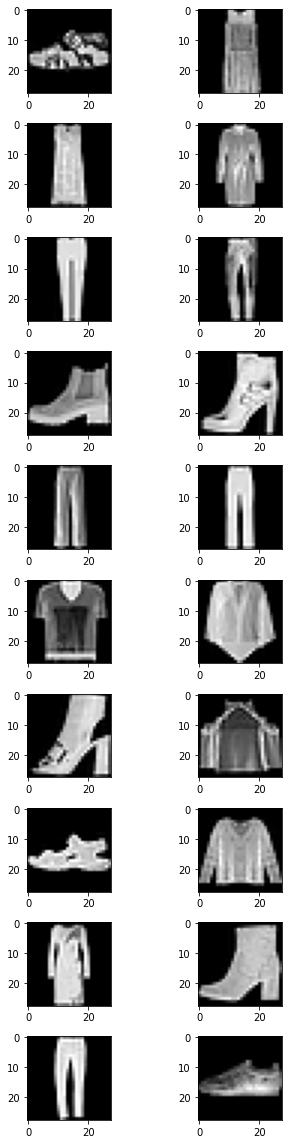

In [9]:
X1, X2, y = next(iter(train_loader))
print(X1[0].shape)
fig=plt.figure(tight_layout=True, figsize=(8, 16))
rows=10
for i in range(rows):
    print(f"y[{i}]={y[i]}")
    ax = fig.add_subplot(rows, 2, i*2+1)
    ax.imshow(X1[i][0].numpy(), cmap='gray')                          # X1[i].shape = (1, 28, 28)，X1[i][0].shape = (28, 28)
    ax = fig.add_subplot(rows, 2, i*2+2)
    ax.imshow(X2[i][0].numpy(), cmap='gray') 

<font size="5">モデルの構築

super()はあるクラス（子クラス）で別のクラス（親クラス）を継承できる。継承することで、親クラスのメソッドを子クラスから呼び出すことができる。
以下の形式
super().親クラスのメソッド

In [10]:
class BaseNetwork(nn.Module):
    """
    Base network for Siamese Network.
    This will be shared between two input images.
    """
    def __init__(self):
        super().__init__()

        # Define the layers
        # Using similar architecture as in the Keras example

        # First Convolutional Layer
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.act1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Second Convolutional Layer
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.act2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Flatten and Dense Layers
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * 7 * 7, 128)  # Assuming input image size is 28x28
        self.act3 = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 256)
        self.act4 = nn.ReLU()

    def forward_1(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.act1(x)
        x = self.maxpool1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.act2(x)
        x = self.maxpool2(x)

        x = self.flatten(x)
        x = self.fc1(x)
        x = self.act3(x)
        x = self.dropout(x)
        x = self.fc2(x)
#         print("xのshape",x)
        x = self.act4(x)

        return x

    def forward(self, x1,x2):
        z1=self.forward_1(x1)
        z2=self.forward_1(x2)
        return z1,z2

# Test the base network with a sample input
base_network = BaseNetwork().to(device)
sample_input = torch.randn(8, 1, 28, 28).to(device)  # Batch of 8 images of sizammm28x28 with 1 channel
sample_output = base_network.forward_1(sample_input)

sample_output.shape  # Expected: [8, 256]


C:\Users\y9723\anaconda3\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


torch.Size([8, 256])

In [11]:
# Siamse Networkモデルクラス
import torch.nn as nn

class SiameseCNNMnistModel(nn.Module):
    
    def __init__(self):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, padding=2), # 28x28x32
            nn.ReLU(),
            nn.MaxPool2d(2,2),                         # 14x14x32
            nn.Conv2d(32, 64, kernel_size=5, padding=2),# 14x14x64
            nn.ReLU(),
            nn.MaxPool2d(2,2)                          # 7x7x64
        )

        # Fully connected layers to get embeddings
        self.fc = nn.Sequential(
            nn.Linear(7*7*64, 256),
            nn.ReLU(),
            nn.Linear(256, 3)
        )
    
    def forward_once(self, x):
        x = self.encoder(x)
        x = x.view(x.size()[0], -1)  # Flatten
        z = self.fc(x)
        return z
  
    def forward(self, x1, x2):
        z1 = self.forward_once(x1)
        z2 = self.forward_once(x2)
        return z1, z2


<font size="5">損失関数

In [12]:
# 損失関数
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=2.5):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, z1, z2, y):
        difference = z1 - z2
        distance_squared = torch.sum(torch.pow(difference, 2), 1)
        distance = torch.sqrt(distance_squared)       #平均：0.813，最大：1.663，最小：0.023，中央値：0.492
        negative_distance = self.margin - distance
        negative_distance = torch.clamp(negative_distance, min=0.0)
        loss = (abs(y) * (distance_squared+2) + abs(1 - abs(y)) * torch.pow(negative_distance, 2)) / 2.0
        loss = torch.sum(loss) / z1.size()[0]
        return loss

<font size ="5">使用関数の一覧実行

In [13]:
#u,vの更新関数
def u_optimize(d):
    u=np.zeros((data_size, class_num+1)) # +1はノイズ分
    for k in range(data_size):
        if 0 not in d[k]:
            for i in range(class_num+1):
                for j in range(class_num+1):
                    u[k][i] = u[k][i] + (d[k][i]/d[k][j])**(1/(m-1))
                u[k][i]=1/u[k][i]
        else:
            for i in range(class_num):
                if d[k][i]==0:
                    u[k][i] = 1
                else:
                    u[k][i]=0
    return u

def v_optimize(u_prime):
    u_except_noise = u_prime[:,1:]
    v = np.zeros((class_num,n_features))
    #分母計算
    v_denominator=np.sum(u_except_noise,axis=0)
    #分子計算
    v_numerator = np.zeros((class_num,n_features))
    for i in range(class_num):
        for k in range(data_size):
            v_numerator[i]=v_numerator[i]+u_except_noise[k][i]*z_valid_np[k]
    for i in range(class_num):
        v[i]= v_numerator[i]/v_denominator[i]
    return v

def noise_clustering(data_size, class_num, max_iter, m, gamma, J, best_J):
    for s in range(max_iter):
        # 初期クラスター中心
        v=z_valid_np[np.random.choice(data_size, class_num)]
        for epoch in range(max_iter):
            for k in range(data_size):
                # データから各重心までの距離の二乗を計算
                d[k][1:]=np.sum((v-z_valid_np[k])**2, axis=1)
            # uの更新
            u=u_optimize(d)
            u_prime=np.power(u, m)
            # vの更新
            v_prime=v_optimize(u_prime)
            #収束条件作成
            for i in range(class_num):
                v_difference = np.linalg.norm(v_prime[i]-v[i], ord=2)
            #収束判定
            if v_difference.min() < epsilon:
                break
            #値のリセット
            v = np.copy(v_prime)


        # 目的関数の計算
        J = np.sum(u_prime[:,1:] * d[:,1:]) + np.sum(u_prime[:,0] * (gamma)**2)
        # 目的関数の値を最適化
        if s==0 or J < best_J:
            best_J = J
            best_u = np.copy(u)
            best_v = np.copy(v_prime)
            #帰属クラスターの決定と格納
            cluster = np.argmax(best_u,axis=1)
    print("クラスター中心は")
    print(best_v.shape)
    print(best_v)
    print("目的関数は"+str(best_J))
    print(cluster)
    return best_v, cluster

In [14]:
# 距離関数
def calculate_distances(data1, data2):
    # data1 の各行と data2 とのユークリッド距離を計算
    distances = np.linalg.norm(data1 - data2, axis=1)

    return distances

def calculate_distances_normal(data1, data2):
    # numpyのユークリッド距離関数を使用して距離を計算
    distance = np.linalg.norm(data1 - data2)
    return distance


#重心を算出
def caluc_cluster(data, labels, i, class_num):
    x_1 = np.mean(data[labels==i, 0], axis=0)
    y_1 = np.mean(data[labels==i, 1], axis=0)
    z_1 = np.mean(data[labels==i, 2], axis=0)
    centroids=(x_1, y_1, z_1)
#     print("ラベル", i, "の重心：", x_1, y_1, z_1)
    return centroids

# ノイズクラスタリング


# 単位球面上に写像する関数
def norm(data):
    norm_data=data.copy()
    for i in range(len(data)):
        norm_data[i]=data[i] / np.linalg.norm(data[i], ord=2)
    return norm_data


def caluc_rotation_main(data):
    # 値の入力
    x=data[0, 0]
    y=data[0, 1]
    z=data[0, 2]
    
    # xの回転
    theta_1 = np.arctan2(y, z)
    
    x_rot_0 = x
    x_rot_1 = y*np.cos(theta_1) - z*np.sin(theta_1)
    x_rot_2 = y*np.sin(theta_1)+z*np.cos(theta_1)
    
    # 値の更新
    x=x_rot_0
    y=x_rot_1
    z=x_rot_2
    
    # yの回転
    theta_2 = np.arctan2(-x, z)
    
    y_rot_0 = x*np.cos(theta_2) + z*np.sin(theta_2)
    y_rot_1 = y
    y_rot_2 = -x*np.sin(theta_2) + z*np.cos(theta_2)
    
    ans=(y_rot_0, y_rot_1, y_rot_2)
    theta=theta_1, theta_2
    
    return ans, theta

def caluc_rotation_sub(data, theta):
    ans=np.zeros((9,3))
    for i in range(1,data.shape[0]):
        # 値の入力
        x=data[i, 0]
        y=data[i, 1]
        z=data[i, 2]

        # xの回転
        theta_1 = theta[0]

        x_rot_0 = x
        x_rot_1 = y*np.cos(theta_1) - z*np.sin(theta_1)
        x_rot_2 = y*np.sin(theta_1)+z*np.cos(theta_1)

        # 値の更新
        x=x_rot_0
        y=x_rot_1
        z=x_rot_2

        # yの回転
        theta_2 = theta[1]

        y_rot_0 = x*np.cos(theta_2) + z*np.sin(theta_2)
        y_rot_1 = y
        y_rot_2 = -x*np.sin(theta_2) + z*np.cos(theta_2)
        print(i)
        ans[i-1]=(y_rot_0, y_rot_1, y_rot_2)
    
    return ans

def caluc_rotation_data(data, theta):
    ans=np.zeros((data.shape[0],data.shape[1]))
#     print(ans.shape)
    for i in range(data.shape[1]):
        # 値の入力
        x=data[:, 0]
        y=data[:, 1]
        z=data[:, 2]

        # xの回転
        theta_1 = theta[0]

        x_rot_0 = x
        x_rot_1 = y*np.cos(theta_1) - z*np.sin(theta_1)
        x_rot_2 = y*np.sin(theta_1)+z*np.cos(theta_1)

        # 値の更新
        x=x_rot_0
        y=x_rot_1
        z=x_rot_2

        # yの回転
        theta_2 = theta[1]

        y_rot_0 = x*np.cos(theta_2) + z*np.sin(theta_2)
        y_rot_1 = y
        y_rot_2 = -x*np.sin(theta_2) + z*np.cos(theta_2)
        ans=(y_rot_0, y_rot_1, y_rot_2)
        
    
    return ans


<font size ="5">学習の準備

In [15]:
import torch.optim as optim
from torchsummary import summary

#モデルのインスタンス化
model=SiameseCNNMnistModel().to(device)
print(model.parameters)
# ？？？？
summary(model, input_size=[(1, 28, 28), (1, 28, 28)])      # 入力が２つあるので（ペア画像だから）input_sizeはリストで複数指定する

# 最適化関数の定義
optimizer=optim.SGD(model.parameters(), lr=0.05)

# 損失関数のインスタンス化
criterion=ContrastiveLoss()

<bound method Module.parameters of SiameseCNNMnistModel(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=3136, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=3, bias=True)
  )
)>
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             832
              ReLU-2           [-1, 32, 28, 28]               0
         MaxPool2d-3           [-1, 32, 14, 14]               0
            Conv2d-4           [-1, 64, 14, 14]          51,264
              

<font size ="5">学習の実行

In [16]:
# import copy
# import matplotlib.pyplot as plt
# from tqdm.notebook import tqdm

# # モデル学習
# repeat = 30                                                      # 学習回数
# losses = []                                                       # 表示用損失値配列

# model.train()                                                     # 学習モード
# for epoch in range(repeat): 
#   print(f"epoch={epoch}")
#   nan_count = 0
#   normal_count = 0




#   # tqdmを使って学習の進行状況を表示
#   for X1, X2, y in tqdm(train_loader, desc=f"Epoch {epoch+1}/{repeat}"):                                  
#     # モデルによる特徴ベクトル算出
#     output1, output2 = model(X1.to(device), X2.to(device))

#     # 損失関数の計算
#     loss = criterion(output1, output2, y.to(device))

#     # nan対策（lossにnanが含まれていれば１回前のモデルに戻す）
#     if torch.isnan(loss):
#       model = prev_model
#       optimizer = optim.SGD(model.parameters(), lr=0.05)
#       optimizer.load_state_dict(prev_optimizer.state_dict())
#       nan_count += 1
#       continue
#     else:
#       prev_model = copy.deepcopy(model)
#       prev_optimizer = copy.deepcopy(optimizer)
#       normal_count += 1

#     # 表示用lossデータの記録
#     losses.append(loss.item())

#     # 勾配を初期化
#     optimizer.zero_grad()
    
#     # 損失関数の値から勾配を求め誤差逆伝播による学習実行
#     loss.backward()
    
#     # 学習結果に基づきパラメータを更新
#     optimizer.step()

#   print(f"nan/normal: {nan_count}/{normal_count}")
# plt.plot(losses)                                                  # loss値の推移を表示


<font size ="5">学習結果の保存

In [17]:
# torch.save(model.state_dict(), 'model_weights_epochs_margin_2.5.pth')

<font size ="5">学習済みの重みを再利用する場合

In [18]:
model.load_state_dict(torch.load('model_weights_epochs_10_23.pth'))

<All keys matched successfully>

<font size ="5">モデルの出力ベクトルの取得

モデル学習の結果、同じクラスに属する画像の出力ベクトルは近くに、異なる数字に属する画像の出力ベクトルは遠くに配置されているはず。
これを確認するために、テストデータを用いて出力ベクトルを集める。
model.eval()で評価モードに設定し、変数の勾配も再計算されないようにtorch.no_grid()を記述する。

In [19]:
# モデル評価
model.eval()                                                      # 評価モード
with torch.no_grad():
    z_valid = []
    y_valid = []
    for X, y in train_loader_prime:                                      # テスト用DataLoader
        z_valid.append(model.forward_once(X.to(device)))           # テストデータをモデルに通して出力ベクトルを得る
        y_valid.append(y)                                          # ラベル（靴、シャツ）の代わりにラベルIDとして0～9の数代わり振られている
    z_valid = torch.cat(z_valid, dim=0)                             # 多次元torch.tensor要素のリストをtorch.tensor化
    y_valid = torch.tensor(y_valid)                                 # スカラ要素(int)リストをtorch.tensor化

In [20]:
# 次元数の確認
print(z_valid.size())
print(y_valid.size())

torch.Size([60000, 3])
torch.Size([60000])


z_testとy_testをGPUに移動

In [21]:
# GPUが利用可能かチェック
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

# z_validとy_validをGPUに移動
z_valid = z_valid.to(device)
y_valid = y_valid.to(device)
# ndarrayに変換
z_valid_np = z_valid.to('cpu').detach().numpy().copy()
y_valid_np = y_valid.to('cpu').detach().numpy().copy()
print(z_valid_np.shape)
print(y_valid_np.shape)

(60000, 3)
(60000,)


<font size="5">モデル出力ベクトルの分布可視化

<IPython.core.display.Javascript object>


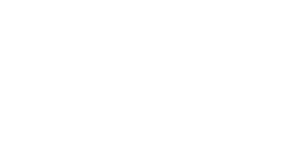

In [22]:
%matplotlib notebook
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# クラス名
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
# クラス数
class_num=len(class_names)
# 事前に定義された10色のリスト
colors = ["blue","green","red","cyan","magenta","yellow","black",'purple','#a65628','#ff7f00']
# figureを生成する
plt.figure(figsize=(10, 10))
# axをfigureに設定する
ax = plt.subplot(111, projection='3d')
# クラスごとに色を分けてプロット
for i in range(class_num):    ax.scatter(z_valid_np[y_valid_np==i, 0], z_valid_np[y_valid_np==i, 1], z_valid_np[y_valid_np==i, 2], color=colors[i], label=class_names[i])
ax.legend()  # 凡例の追加
plt.show()

<IPython.core.display.Javascript object>


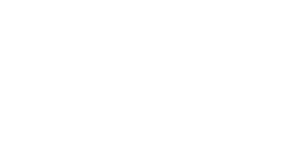

In [23]:
%matplotlib notebook
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# クラス名
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
# クラス数
class_num=len(class_names)
# 事前に定義された10色のリスト
colors = ["blue","green","red","cyan","magenta","yellow","black",'purple','#a65628','#ff7f00']
# figureを生成する
plt.figure(figsize=(10, 10))
# axをfigureに設定する
ax = plt.subplot(111, projection='3d')
# クラスごとに色を分けてプロット
ax.scatter(z_valid_np[y_valid_np==6, 0], z_valid_np[y_valid_np==6, 1], z_valid_np[y_valid_np==6, 2], color=colors[6], label=class_names[6])
ax.scatter(z_valid_np[y_valid_np==0, 0], z_valid_np[y_valid_np==0, 1], z_valid_np[y_valid_np==0, 2], color=colors[0], label=class_names[0])
ax.scatter(z_valid_np[y_valid_np==2, 0], z_valid_np[y_valid_np==2, 1], z_valid_np[y_valid_np==2, 2], color=colors[2], label=class_names[2])

ax.legend()  # 凡例の追加
plt.show()

<font size="5">ノイズクラスタリングなし

<IPython.core.display.Javascript object>


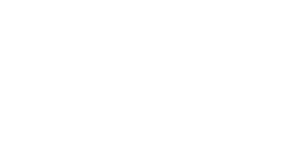

In [24]:
%matplotlib notebook
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


# 重心格納用のリスト
centroids=np.zeros((class_num, 3))
# クラス名
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
# クラス数
class_num=len(class_names)
# 事前に定義された10色のリスト
colors = ["blue","green","red","cyan","magenta","yellow","black",'#f781bf','#a65628','#ff7f00']
# figureを生成する
plt.figure(figsize=(10, 10))
# axをfigureに設定する
ax = plt.subplot(111, projection='3d')

# 重心の算出
for i in range(class_num):
    centroids[i]=caluc_cluster(z_valid_np, y_valid_np, i, class_num)

# クラスごとに色を分けてプロット
for i in range(class_num):
#     ax.scatter(z_valid_np[y_valid_np==i, 0], z_valid_np[y_valid_np==i, 1], z_valid_np[y_valid_np==i, 2], color=colors[i], label=class_names[i])
    ax.scatter(centroids[i, 0], centroids[i, 1], centroids[i, 2], marker='*', color=colors[i], label=class_names[i], s=500, edgecolors="black")
ax.legend()  # 凡例の追加
plt.show()

<font size="5">ノイズクラスタリングあり

<font size="5">ノイズクラスタリングありなしの比較

<font size="5">判定領域作成関数

判定領域作成のステップを以下に示す   
１．ノイズクラスタリングにより算出した重心を可視化→処理時間がかかるためデータ数を減らして行う？  
２．重心から領域を広げていく（同心円状に安全マージンの導入をしてみてもいいかも）  
３．重心内の含有量を算出し、一定値以上となった場合広げるのをやめる  
４．以上により三次元空間の判定領域を作成     
→同心円状の場合は、判定領域内かどうかは半径と点同士の距離を測定して算出が可能  

In [25]:
# まず一つのクラスタに対する処理を記載する
"""
1．クラスタ中心と所属サンプルの距離を計算し最大距離を算出（やはりノイズがあるから四分位数などを使うといいかも）
2. 他クラスサンプルとの距離を求めていき、最小距離の更新をしていく（処理量を落とすために、クラスタ距離から絞るのあり2,3クラスまで？）
3. 最小距離（-margin）を半径とする球を作成し、その内部を判別領域とする
"""
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
# 半径格納用
radius_class=np.zeros((10,))

# クラスタ中心
for i in range(class_num):
    print(class_names)
    # 同クラスの中で最も遠い距離を算出
    dis_same=calculate_distances(z_valid_np[y_valid_np==i], centroids[i])
    max_dis=np.max(dis_same)
    print(f"クラス{i}内の最大距離：{max_dis}")
    # 他クラスとの距離を求めていく
    # クラスタ同士の距離を計算
    main_centroid=centroids[i]
    sub_centroids=np.delete(centroids, i, axis=0)
    class_names_1=['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
    del class_names_1[i]
    dis_centroids=calculate_distances(sub_centroids, main_centroid)
    sorted_dis_centroids=np.argsort(dis_centroids)
    # 最小の2つの要素のインデックスを取得
    indices_of_min_values = sorted_dis_centroids[:2]
    selected_class_names = [class_names_1[i] for i in indices_of_min_values]
    print(class_names_1)
    print(f"クラス{i}との最小距離の2つの要素のインデックス:{selected_class_names}")
    # 取得したインデックス所属するサンプルと目的クラスタの距離を計算して最小の値を算出する（margin2の導入？）
    # 選択したクラス名に対応するclass_namesのインデックスを取得
    selected_indices = [class_names.index(class_name) for class_name in selected_class_names]

    # 取得したインデックスを使用してforループを実行
    minimum=float("inf")
    min_index=0
    for index in selected_indices:
        print(f"Index: {index}, Class Name: {class_names[index]}")
        dis_dif=calculate_distances(z_valid_np[y_valid_np==index], centroids[i])
        index_can=np.argmin(dis_dif)
        if dis_dif[index_can] < minimum:
            minimum=dis_dif[index_can]
            min_index=index_can
    print(f"クラス{i}の半径の値：{minimum}")
    radius_class[i]=minimum
            

['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
クラス0内の最大距離：1.8284612081400262
['Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
クラス0との最小距離の2つの要素のインデックス:['Shirt', 'Dress']
Index: 6, Class Name: Shirt
Index: 3, Class Name: Dress
クラス0の半径の値：0.023947179938308166
['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
クラス1内の最大距離：1.7914118594551809
['T-shirt/top', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
クラス1との最小距離の2つの要素のインデックス:['Dress', 'Sandal']
Index: 3, Class Name: Dress
Index: 5, Class Name: Sandal
クラス1の半径の値：0.2403802354730656
['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
クラス2内の最大距離：1.8224941766436493
['T-shirt/top', 'Trouser', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
クラス2との最小距離の2つの要素のインデックス:['Coat', 'Shirt']
Inde

<IPython.core.display.Javascript object>


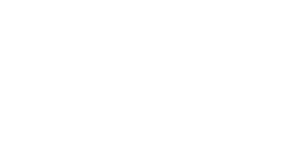

In [26]:

# Step 2: Create random data for each class
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Step 3: Create a figure and axis with a larger figsize
fig, ax = plt.subplots(figsize=(14, 10))  # Adjust the width and height as needed

data= [calculate_distances(z_valid_np[y_valid_np==i], centroids[i]) for i in range(10)]

# Step 4: Create boxplots
boxplot=plt.boxplot(data, vert=False)

# クラス名を設定
plt.yticks(range(1, 11), class_names)

# 外れ値の個数を表示
for i, flier in enumerate(boxplot['fliers']):
    y = flier.get_data()[1]
    num_outliers = len(y)
    plt.text(2.1, i + 1, f'Outliers: {num_outliers} /3000', va='center', fontsize=10, color="blue")

# グラフのタイトルと軸ラベルを設定
plt.title('Box Plot of 10 Classes with 3000 Data Points Each')
plt.xlabel('Data Values')

plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility

plt.show()

ドットプロット図

<IPython.core.display.Javascript object>


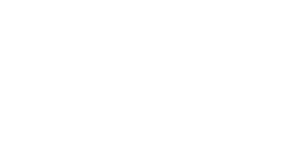

In [27]:
%matplotlib notebook

fig, ax = plt.subplots(figsize=(14, 10))  # Adjust the width and height as needed

# クラス名と色のリスト
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
colors = ["blue","green","red","cyan","magenta","yellow","black",'purple','#a65628','#ff7f00']

for i in range(10):
    for j in range(10):
        dis_sub=calculate_distances(z_valid_np[y_valid_np==j], centroids[i])
        plt.scatter(dis_sub, np.ones_like(dis_sub) * (10-i), color=colors[j], label=class_names[i], s=0.5)

# クラス名を設定
plt.yticks(range(10, 0, -1), class_names)
plt.xlabel('Data Value')
plt.title('Dot Plot of One-Dimensional Data')
plt.grid(axis='x')  # x軸にグリッドを表示
plt.show()

In [28]:
radius_class
radius_class_arbitary=[0.1, 0.25, 0.08, 0.3, 0.15, 0.5, 0.2, 0.4, 0.6, 0.8]
radius_class_arbitary=np.array(radius_class_arbitary)

<IPython.core.display.Javascript object>


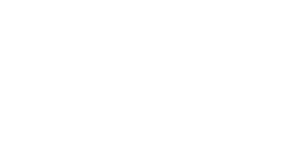

In [29]:
%matplotlib notebook
from pylab import rcParams
rcParams['figure.figsize'] = 10, 10


# 球体のパラメータ
radius = radius_class_arbitary
phi = np.linspace(0, np.pi, 15)  # 緯度角の範囲
theta = np.linspace(0, 2 * np.pi, 30)  # 経度角の範囲
phi, theta=np.meshgrid(phi, theta)

# figureを生成する
fig=plt.figure()
# axをfigureに設定する
ax = fig.add_subplot(111, projection='3d')

# 球体の座標を計算
for i in range(10):
    x = radius[i] * np.sin(phi) * np.cos(theta)+centroids[i, 0]
    y = radius[i] * np.sin(phi) * np.sin(theta)+centroids[i, 1]
    z = radius[i] * np.cos(phi)+centroids[i, 2]
    ax.scatter(centroids[i, 0], centroids[i, 1], centroids[i, 2], marker='*', color=colors[i], label=class_names[i], s=100, edgecolors="black")
    ax.plot_surface(x, y, z, color=colors[i], label=class_names[i], alpha=0.5)

    
ax.set_xlim([-2,2])
ax.set_ylim([-2,2])
ax.set_zlim([-2,2])
# ax.legend()  # 凡例の追加
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


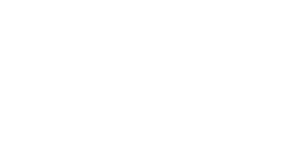

In [30]:
%matplotlib notebook
from pylab import rcParams
rcParams['figure.figsize'] = 10, 10

# 球体のパラメータ
radius = radius_class
phi = np.linspace(0, np.pi, 15)  # 緯度角の範囲
theta = np.linspace(0, 2 * np.pi, 30)  # 経度角の範囲
phi, theta = np.meshgrid(phi, theta)

# figureを生成する
fig = plt.figure()
# axをfigureに設定する
ax = fig.add_subplot(111, projection='3d')

# 球体の座標を計算
for i in range(10):
    x = radius[i] * np.sin(phi) * np.cos(theta) + centroids[i, 0]
    y = radius[i] * np.sin(phi) * np.sin(theta) + centroids[i, 1]
    z = radius[i] * np.cos(phi) + centroids[i, 2]
    ax.plot_surface(x, y, z, color=colors[i], alpha=0.5)
    ax.scatter(centroids[i, 0], centroids[i, 1], centroids[i, 2], marker='*', color=colors[i], label=class_names[i], s=500, edgecolors="black")


# 凡例を手動で作成
legend_labels = []
for i in range(10):
    legend_labels.append(plt.Line2D([0], [0], marker='o', color=colors[i], markersize=5, label=class_names[i]))

# 星印の凡例も追加
legend_labels.append(plt.Line2D([0], [0], marker='*', color="black", markersize=10, label='Centroid'))

ax.set_xlim([-2, 2])
ax.set_ylim([-2, 2])
ax.set_zlim([-2, 2])
ax.legend(handles=legend_labels)  # 凡例の追加

plt.tight_layout()
plt.show()


In [31]:
%matplotlib notebook
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


rcParams['figure.figsize'] = 10, 10

# 球体のパラメータ
radius = radius_class_arbitary
phi = np.linspace(0, np.pi, 15)  # 緯度角の範囲
theta = np.linspace(0, 2 * np.pi, 30)  # 経度角の範囲
phi, theta = np.meshgrid(phi, theta)

# クラス名
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
# クラス数
class_num=len(class_names)
# 事前に定義された10色のリスト
colors = ["blue","green","red","cyan","magenta","yellow","black",'#f781bf','#a65628','#ff7f00']
# figureを生成する
plt.figure(figsize=(10, 10))
# axをfigureに設定する
ax = plt.subplot(111, projection='3d')
# クラスごとに色を分けてプロット
for i in range(class_num):    
    ax.scatter(z_valid_np[y_valid_np==i, 0], z_valid_np[y_valid_np==i, 1], z_valid_np[y_valid_np==i, 2], color=colors[i], label=class_names[i], alpha=0.02)

# 球体の座標を計算
for i in range(10):
    x = radius[i] * np.sin(phi) * np.cos(theta) + centroids[i, 0]
    y = radius[i] * np.sin(phi) * np.sin(theta) + centroids[i, 1]
    z = radius[i] * np.cos(phi) + centroids[i, 2]
    ax.plot_surface(x, y, z, color=colors[i], alpha=0.5, edgecolors="black")
    ax.scatter(centroids[i, 0], centroids[i, 1], centroids[i, 2], marker='*', color=colors[i], label=class_names[i], s=300, edgecolors="black")

    
# 凡例を手動で作成
legend_labels = []
for i in range(10):
    legend_labels.append(plt.Line2D([0], [0], marker='o', color=colors[i], markersize=5, label=class_names[i]))

# 星印の凡例も追加
legend_labels.append(plt.Line2D([0], [0], marker='*', color="black", markersize=10, label='Centroid'))

ax.set_xlim([-2, 2])
ax.set_ylim([-2, 2])
ax.set_zlim([-2, 2])
ax.legend(handles=legend_labels)  # 凡例の追加
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>

<font size="5">testデータで性能判定

1. CNNから(3,)の出力を受け取る
2, 各クラスタとの距離を算出して最小のものを選択→半径以内かどうか判定（二十判定、判定がない場合に予測不可とする）

In [32]:
# モデル評価
model.eval()                                                      # 評価モード
with torch.no_grad():
    z_test = []
    y_test = []
    for X, y in test_loader:                                      # テスト用DataLoader
        z_test.append(model.forward_once(X.to(device)))           # テストデータをモデルに通して出力ベクトルを得る
        y_test.append(y)                                          # ラベル（靴、シャツ）の代わりにラベルIDとして0～9の数代わり振られている
    z_test = torch.cat(z_test, dim=0)                             # 多次元torch.tensor要素のリストをtorch.tensor化
    y_test = torch.tensor(y_test)

# z_testとy_testをGPUに移動
z_test = z_test.to(device)
y_test = y_test.to(device)
# ndarrayに変換
z_test_np = z_test.to('cpu').detach().numpy().copy()
y_test_np = y_test.to('cpu').detach().numpy().copy()
print(z_test_np.shape)
print(y_test_np.shape)

(1000, 3)
(1000,)


<font size="5">testデータに対して判定領域を作成

判定領域作成のステップを以下に示す   
１．testデータを受け取る  
２．testデータからの距離（球、立方体）の領域を獲得、その条件に合うデータを取ってきて、ラベルを確認する  
３．ラベルから領域判定条件を設定する。し、解答を算出

In [33]:
# 予測ラベル格納
predictions=np.zeros((z_test_np.shape[0],))
z_test_np
# 複製の作成
sub_y_test=y_test_np.copy()

# 半径のパラメータ(0.1, 0.3, 0.5, 0.7, 0.9, 1)
# test_radius=[0.01, 0.05, 0.1, 0.3, 0.5, 0.7, 0.9]
test_radius=0.4
# 割合パラメータ（50, 60, 70, 80, 90, 95）
para=90
# 四角形を作ってから、球状判定領域を作成
array=np.array(z_valid_np.shape)
percentage=np.empty(10)

for l in range(z_test_np.shape[0]):
    # 四角形内か否かを判定
    array=(z_test_np[l]-test_radius < z_valid_np) & (z_valid_np < z_test_np[l]+test_radius)
#     print(array.shape)
    array1=array.all(axis=1)
#     print(array1.shape)
#     print(array1)
    array2=z_valid_np[array1]   
#     print(array2.shape)
    # totalの計算
    total_elements=array2.shape[0]
    # labelの確認
    array3=y_valid_np[array1]
#     print(type(array3))
    counts=np.bincount(array3, minlength=10)
    # 結果の表示
    for i in range(10):
        percentage[i] = (counts[i] / total_elements) * 100
#         print(f"クラス {i} は {counts[i]} 回出現しました。割合は {percentage[i]:.2f}% です。")
#     print("--------------------------------------------------------------------")
    # percentageがpara%を超えていればそのラベルを予測ラベルとし、そうでない場合は、他のラベルの割合比べたり、不可能ラベルとしたり
    #     条件分岐
    max_value = np.max(percentage)
#     print(f"max_value:{max_value}")
    max_index = np.argmax(percentage)
#     print(f"max_index:{max_index}")
    if para < max_value:
        predictions[l]=max_index
    else:
        predictions[l]=10 # 最小半径異常の距離の場合分類不可とする
        
# ラベルごとの正解、不正解、解答不能のカウントを辞書として初期化
label_counts = {label: {"correct": 0, "incorrect": 0, "unanswerable": 0} for label in range(class_num)}
        
# 予測と正解ラベルを比較し、各ラベルのカウントを更新
for i in range(len(predictions)):
    prediction = predictions[i]
    label = y_test_np[i]

    if prediction == label:
        label_counts[label]["correct"] += 1
    elif prediction == 10:
        label_counts[label]["unanswerable"] += 1
        sub_y_test[i]=10
    else:
        label_counts[label]["incorrect"] += 1
        
pre=predictions.copy()    
# ラベルごとのカウントをデータフレームに変換
count_df = pd.DataFrame(label_counts)

# ラベルが10の行を削除
count_df = count_df[count_df.index != 10]

# データフレームを表示
count_df

,0,1,2,3,4,5,6,7,8,9
correct,8,92,5,38,6,61,0,20,88,82
incorrect,0,1,0,0,0,0,0,3,0,0
unanswerable,92,7,95,62,94,39,100,77,12,18


In [34]:
# 予測ラベル格納
predictions=np.zeros((z_test_np.shape[0],))
z_test_np
# 複製の作成
sub_y_test=y_test_np.copy()

# 半径のパラメータ(0.1, 0.3, 0.5, 0.7, 0.9, 1)
# test_radius=[0.01, 0.05, 0.1, 0.3, 0.5, 0.7, 0.9]
test_radius=0.4
# 割合パラメータ（50, 60, 70, 80, 90, 95）
para=90
# 四角形を作ってから、球状判定領域を作成
array=np.array(z_valid_np.shape)
percentage=np.empty(10)

for l in range(z_test_np.shape[0]):
    # 四角形内か否かを判定
    array=(z_test_np[l]-test_radius < z_valid_np) & (z_valid_np < z_test_np[l]+test_radius)
#     print(array.shape)
    array1=array.all(axis=1)
#     print(array1.shape)
#     print(array1)
    array2=z_valid_np[array1]   
#     print(array2.shape)
    # totalの計算
    total_elements=array2.shape[0]
    # labelの確認
    array3=y_valid_np[array1]
#     print(type(array3))
    counts=np.bincount(array3, minlength=10)
    # 結果の表示
    for i in range(10):
        percentage[i] = (counts[i] / total_elements) * 100
#         print(f"クラス {i} は {counts[i]} 回出現しました。割合は {percentage[i]:.2f}% です。")
#     print("--------------------------------------------------------------------")
    # percentageがpara%を超えていればそのラベルを予測ラベルとし、そうでない場合は、他のラベルの割合比べたり、不可能ラベルとしたり
    #     条件分岐
    max_value = np.max(percentage)
#     print(f"max_value:{max_value}")
    max_index = np.argmax(percentage)
#     print(f"max_index:{max_index}")
    if para < max_value:
        predictions[l]=max_index
    else:
        predictions[l]=10 # 最小半径異常の距離の場合分類不可とする
        
# ラベルごとの正解、不正解、解答不能のカウントを辞書として初期化
label_counts = {label: {"correct": 0, "incorrect": 0, "unanswerable": 0} for label in range(class_num)}
        
# 予測と正解ラベルを比較し、各ラベルのカウントを更新
for i in range(len(predictions)):
    prediction = predictions[i]
    label = y_test_np[i]

    if prediction == label:
        label_counts[label]["correct"] += 1
    elif prediction == 10:
        label_counts[label]["unanswerable"] += 1
        sub_y_test[i]=10
    else:
        label_counts[label]["incorrect"] += 1
        
pre=predictions.copy()    
# ラベルごとのカウントをデータフレームに変換
count_df = pd.DataFrame(label_counts)

# ラベルが10の行を削除
count_df = count_df[count_df.index != 10]

# データフレームを表示
count_df

,0,1,2,3,4,5,6,7,8,9
correct,8,92,5,38,6,61,0,20,88,82
incorrect,0,1,0,0,0,0,0,3,0,0
unanswerable,92,7,95,62,94,39,100,77,12,18


In [40]:
# 予測ラベル格納
predictions=np.zeros((z_test_np.shape[0],))
z_test_np
# 複製の作成
sub_y_test=y_test_np.copy()
# 格納用
data=[]
# 半径のパラメータ(0.1, 0.3, 0.5, 0.7, 0.9, 1)
test_radius=[0.05, 0.1, 0.3, 0.5]
# test_radius=0.1
# 割合パラメータ（50, 60, 70, 80, 90, 95）
para=80
# 四角形を作ってから、球状判定領域を作成
array=np.array(z_valid_np.shape)
percentage=np.empty(10)

for index in range(len(test_radius)):
    for l in range(z_test_np.shape[0]):
        # 四角形内か否かを判定
        array=(z_test_np[l]-test_radius[index] < z_valid_np) & (z_valid_np < z_test_np[l]+test_radius[index])
    #     print(array.shape)
        array1=array.all(axis=1)
    #     print(array1.shape)
    #     print(array1)
        array2=z_valid_np[array1]   
    #     print(array2.shape)
        # totalの計算
        total_elements=array2.shape[0]
        # labelの確認
        array3=y_valid_np[array1]
    #     print(type(array3))
        counts=np.bincount(array3, minlength=10)
        # 結果の表示
        for i in range(10):
            percentage[i] = (counts[i] / total_elements) * 100
    #         print(f"クラス {i} は {counts[i]} 回出現しました。割合は {percentage[i]:.2f}% です。")
    #     print("--------------------------------------------------------------------")
        # percentageがpara%を超えていればそのラベルを予測ラベルとし、そうでない場合は、他のラベルの割合比べたり、不可能ラベルとしたり
        #     条件分岐
        max_value = np.max(percentage)
    #     print(f"max_value:{max_value}")
        max_index = np.argmax(percentage)
    #     print(f"max_index:{max_index}")
        if para < max_value:
            predictions[l]=max_index
        else:
            predictions[l]=10 # 最小半径異常の距離の場合分類不可とする
        
    # クラスの数とクラスの名前を定義
    class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
    class_num = len(class_names)

    # ラベルごとの正解、不正解、解答不能のカウントを辞書として初期化
    label_counts = {class_names[label]: {"correct": 0, "incorrect": 0, "unanswerable": 0} for label in range(class_num)}

    # 予測と正解ラベルを比較し、各ラベルのカウントを更新
    for i in range(len(predictions)):
        prediction = predictions[i]
        label = y_test_np[i]

        if prediction == label:
            label_name = class_names[label]
            label_counts[label_name]["correct"] += 1
        elif prediction == 10:
            label_name = class_names[label]
            label_counts[label_name]["unanswerable"] += 1
            sub_y_test[i] = 10
        else:
            label_name = class_names[label]
            label_counts[label_name]["incorrect"] += 1
            
    # dataに格納（三周するはずその間に（10,3）を三回）
    label_2=["correct", "incorrect", "unanswerable"]
    arr=np.zeros(10)
    for j in range(len(label_2)):
        for i in range(len(class_names)):
            arr[i]=label_counts[class_names[i]][label_2[j]]
            print(arr[i])
        arr2=arr.tolist()
        data.append(arr2)
    data2=np.array(data)
    print(data2)
        
print(data2.shape)
# データの形状が（10,9）であるものを取得したい
        
pre=predictions.copy()

# # ラベルごとのカウントをデータフレームに変換
# count_df = pd.DataFrame(label_counts)

# # ラベルが10の行を削除
# count_df = count_df[count_df.index != 10]

# # データフレームを表示
# count_df


C:\Users\y9723\anaconda3\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in longlong_scalars


55.0
92.0
48.0
66.0
49.0
79.0
28.0
72.0
86.0
89.0
5.0
2.0
9.0
4.0
3.0
4.0
13.0
8.0
2.0
2.0
40.0
6.0
43.0
30.0
48.0
17.0
59.0
20.0
12.0
9.0
[[55. 92. 48. 66. 49. 79. 28. 72. 86. 89.]
 [ 5.  2.  9.  4.  3.  4. 13.  8.  2.  2.]
 [40.  6. 43. 30. 48. 17. 59. 20. 12.  9.]]
59.0
93.0
49.0
69.0
43.0
84.0
31.0
75.0
90.0
90.0
3.0
2.0
5.0
3.0
4.0
2.0
7.0
6.0
1.0
3.0
38.0
5.0
46.0
28.0
53.0
14.0
62.0
19.0
9.0
7.0
[[55. 92. 48. 66. 49. 79. 28. 72. 86. 89.]
 [ 5.  2.  9.  4.  3.  4. 13.  8.  2.  2.]
 [40.  6. 43. 30. 48. 17. 59. 20. 12.  9.]
 [59. 93. 49. 69. 43. 84. 31. 75. 90. 90.]
 [ 3.  2.  5.  3.  4.  2.  7.  6.  1.  3.]
 [38.  5. 46. 28. 53. 14. 62. 19.  9.  7.]]
52.0
94.0
30.0
67.0
30.0
82.0
8.0
64.0
94.0
90.0
2.0
1.0
1.0
2.0
2.0
3.0
5.0
5.0
0.0
3.0
46.0
5.0
69.0
31.0
68.0
15.0
87.0
31.0
6.0
7.0
[[55. 92. 48. 66. 49. 79. 28. 72. 86. 89.]
 [ 5.  2.  9.  4.  3.  4. 13.  8.  2.  2.]
 [40.  6. 43. 30. 48. 17. 59. 20. 12.  9.]
 [59. 93. 49. 69. 43. 84. 31. 75. 90. 90.]
 [ 3.  2.  5.  3.  4.  2.  

In [67]:
# 格納用
data=[]
# level0がより左側のインデックスで、階層は上のインデックス
test_radius=[0.01, 0.03, 0.05, 0.08, 0.1, 0.2]
string_test_radius = [str(radius) for radius in test_radius for _ in range(3)]
# print(string_test_radius)
# level0
level0=string_test_radius

label_ans = ["正解", "不正解", "解答不可"]
# test_radiusの値の数に応じてパターンを増やす
level1 = [patterns[j] for i in range(len(test_radius)) for j in range(len(patterns))]
indices = [level0, level1]
# print(indices)

# データの整理

for index in range(len(test_radius)):
    for l in range(z_test_np.shape[0]):
        # 四角形内か否かを判定
        array=(z_test_np[l]-test_radius[index] < z_valid_np) & (z_valid_np < z_test_np[l]+test_radius[index])
    #     print(array.shape)
        array1=array.all(axis=1)
    #     print(array1.shape)
    #     print(array1)
        array2=z_valid_np[array1]   
    #     print(array2.shape)
        # totalの計算
        total_elements=array2.shape[0]
        # labelの確認
        array3=y_valid_np[array1]
    #     print(type(array3))
        counts=np.bincount(array3, minlength=10)
        # 結果の表示
        for i in range(10):
            percentage[i] = (counts[i] / total_elements) * 100
    #         print(f"クラス {i} は {counts[i]} 回出現しました。割合は {percentage[i]:.2f}% です。")
    #     print("--------------------------------------------------------------------")
        # percentageがpara%を超えていればそのラベルを予測ラベルとし、そうでない場合は、他のラベルの割合比べたり、不可能ラベルとしたり
        #     条件分岐
        max_value = np.max(percentage)
    #     print(f"max_value:{max_value}")
        max_index = np.argmax(percentage)
    #     print(f"max_index:{max_index}")
        if para < max_value:
            predictions[l]=max_index
        else:
            predictions[l]=10 # 最小半径異常の距離の場合分類不可とする
        
    # クラスの数とクラスの名前を定義
    class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
    class_num = len(class_names)

    # ラベルごとの正解、不正解、解答不能のカウントを辞書として初期化
    label_counts = {class_names[label]: {"correct": 0, "incorrect": 0, "unanswerable": 0} for label in range(class_num)}

    # 予測と正解ラベルを比較し、各ラベルのカウントを更新
    for i in range(len(predictions)):
        prediction = predictions[i]
        label = y_test_np[i]

        if prediction == label:
            label_name = class_names[label]
            label_counts[label_name]["correct"] += 1
        elif prediction == 10:
            label_name = class_names[label]
            label_counts[label_name]["unanswerable"] += 1
            sub_y_test[i] = 10
        else:
            label_name = class_names[label]
            label_counts[label_name]["incorrect"] += 1
            
    # dataに格納（三周するはずその間に（10,3）を三回）
    label_2=["correct", "incorrect", "unanswerable"]
    arr=np.zeros(10)
    for j in range(len(label_2)):
        for i in range(len(class_names)):
            arr[i]=label_counts[class_names[i]][label_2[j]]
#             print(arr[i])
        arr2=arr.tolist()
        data.append(arr2)
    data2=np.array(data)
#     print(data2)

int_data=data2.astype(int)
column =  ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
print(column)
df = pd.DataFrame(int_data, index=indices, columns=column)
df

C:\Users\y9723\anaconda3\lib\site-packages\ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in longlong_scalars


['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


T-shirt/top  Trouser  Pullover  Dress  Coat  Sandal  Shirt  \
0.01 正解             10       19         5      8    10      11      2   
     不正解             3        0         2      2     4       1      9   
     解答不可           87       81        93     90    86      88     89   
0.03 正解             48       89        44     54    37      73     23   
     不正解             8        4         8     10     8       5     15   
     解答不可           44        7        48     36    55      22     62   
0.05 正解             55       92        48     66    49      79     28   
     不正解             5        2         9      4     3       4     13   
     解答不可           40        6        43     30    48      17     59   
0.08 正解             56       94        49     69    47      84     35   
     不正解             7        2         7      4     3       1      8   
     解答不可           37        4        44     27    50      15     57   
0.1  正解             59       93        49     69    43      84     31   
     不正解             3        2         5      3     4       2      7   
     解答不可           38        5        46     28    53      14     62   
0.2  正解             57       95        44     69    40      84     25   
     不正解             2        1         3      2     3       3      6   
     解答不可           41        4        53     29    57      13     69   

           Sneaker  Bag  Ankle boot  
0.01 正解          7    5          21  
     不正解         0    1           1  
     解答不可       93   94          78  
0.03 正解         71   77          82  
     不正解        10    2           5  
     解答不可       19   21          13  
0.05 正解         72   86          89  
     不正解         8    2           2  
     解答不可       20   12           9  
0.08 正解         74   91          88  
     不正解         6    2           5  
     解答不可       20    7           7  
0.1  正解         75   90          90  
     不正解         6    1           3  
     解答不可       19    9           7  
0.2  正解         71   94          91  
     不正解         6    0           3  
     解答不可       23    6           6

In [36]:
# ラベルごとの正解、不正解、解答不能のカウントを辞書として初期化
label_counts = {class_names[label]: {"correct": 0, "incorrect": 0, "unanswerable": 0} for label in range(class_num)}

# test_radiusをループ
for radius in [0.01, 0.05, 0.1]:
    print(f"Results for test_radius = {radius}:")
    predictions = np.zeros((z_test_np.shape[0],))
    
    for l in range(z_test_np.shape[0]):
        array = (z_test_np[l] - radius < z_valid_np) & (z_valid_np < z_test_np[l] + radius)
        array1 = array.all(axis=1)
        array2 = z_valid_np[array1]
        total_elements = array2.shape[0]
        array3 = y_valid_np[array1]
        counts = np.bincount(array3, minlength=10)
        
        percentage = (counts / total_elements) * 100
        
        max_value = np.max(percentage)
        max_index = np.argmax(percentage)
        
        if para < max_value:
            predictions[l] = max_index
        else:
            predictions[l] = 10
        
    # ラベルごとの正解、不正解、解答不能のカウントを更新
    for i in range(len(predictions)):
        prediction = predictions[i]
        label = y_test_np[i]

        if prediction == label:
            label_name = class_names[label]
            label_counts[label_name]["correct"] += 1
        elif prediction == 10:
            label_name = class_names[label]
            label_counts[label_name]["unanswerable"] += 1
            sub_y_test[i] = 10
        else:
            label_name = class_names[label]
            label_counts[label_name]["incorrect"] += 1

    # ラベルが10の行を削除
    count_df = pd.DataFrame(label_counts)
    count_df = count_df[count_df.index != 10]

    # データフレームを表示
    print(count_df)
    print("--------------------------------------------------------------------")


Results for test_radius = 0.01:


C:\Users\y9723\anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide


              T-shirt/top  Trouser  Pullover  Dress  Coat  Sandal  Shirt  \
correct                10       19         5      8    10      11      2   
incorrect               3        0         2      2     4       1      9   
unanswerable           87       81        93     90    86      88     89   

              Sneaker  Bag  Ankle boot  
correct             7    5          21  
incorrect           0    1           1  
unanswerable       93   94          78  
--------------------------------------------------------------------
Results for test_radius = 0.05:


C:\Users\y9723\anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide


              T-shirt/top  Trouser  Pullover  Dress  Coat  Sandal  Shirt  \
correct                65      111        53     74    59      90     30   
incorrect               8        2        11      6     7       5     22   
unanswerable          127       87       136    120   134     105    148   

              Sneaker  Bag  Ankle boot  
correct            79   91         110  
incorrect           8    3           3  
unanswerable      113  106          87  
--------------------------------------------------------------------
Results for test_radius = 0.1:


C:\Users\y9723\anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide


              T-shirt/top  Trouser  Pullover  Dress  Coat  Sandal  Shirt  \
correct               124      204       102    143   102     174     61   
incorrect              11        4        16      9    11       7     29   
unanswerable          165       92       182    148   187     119    210   

              Sneaker  Bag  Ankle boot  
correct           154  181         200  
incorrect          14    4           6  
unanswerable      132  115          94  
--------------------------------------------------------------------


In [37]:
import numpy as np
import pandas as pd

# 予測ラベル格納
predictions = np.zeros((z_test_np.shape[0],))
sub_y_test = y_test_np.copy()

# 半径のパラメータ(0.01, 0.05, 0.1)
test_radii = [0.01, 0.05, 0.1]
para = 80  # 割合パラメータ（50, 60, 70, 80, 90, 95）

# クラスの数とクラスの名前を定義
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
class_num = len(class_names)

for radius in test_radii:
    # 球状判定領域を作成
    percentage = np.empty(10)

    for l in range(z_test_np.shape[0]):
        # 四角形内か否かを判定
        array = (z_test_np[l] - radius < z_valid_np) & (z_valid_np < z_test_np[l] + radius)
        array1 = array.all(axis=1)
        array2 = z_valid_np[array1]
        total_elements = array2.shape[0]
        array3 = y_valid_np[array1]
        counts = np.bincount(array3, minlength=10)
        for i in range(10):
            percentage[i] = (counts[i] / total_elements) * 100

        max_value = np.max(percentage)
        max_index = np.argmax(percentage)
        if para < max_value:
            predictions[l] = max_index
        else:
            predictions[l] = 10  # 最小半径異常の距離の場合分類不可とする

    pre = predictions.copy()
    # ラベルごとの正解、不正解、解答不能のカウントを辞書として初期化
    label_counts = {class_names[label]: {"correct": 0, "incorrect": 0, "unanswerable": 0} for label in range(class_num)}
    # 予測と正解ラベルを比較し、各ラベルのカウントを更新
    for i in range(len(predictions)):
        prediction = predictions[i]
        label = y_test_np[i]

        if prediction == label:
            label_name = class_names[label]
            label_counts[label_name]["correct"] += 1
        elif prediction == 10:
            label_name = class_names[label]
            label_counts[label_name]["unanswerable"] += 1
            sub_y_test[i] = 10
        else:
            label_name = class_names[label]
            label_counts[label_name]["incorrect"] += 1

    # ラベルごとのカウントをデータフレームに変換
    count_df = pd.DataFrame(label_counts)

    # ラベルが10の行を削除
    count_df = count_df[count_df.index != 10]

    # データフレームを表示
    print(f"Results for test_radius = {radius}:")
    print(count_df)
    print("\n")


C:\Users\y9723\anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in longlong_scalars


Results for test_radius = 0.01:
              T-shirt/top  Trouser  Pullover  Dress  Coat  Sandal  Shirt  \
correct                10       19         5      8    10      11      2   
incorrect               3        0         2      2     4       1      9   
unanswerable           87       81        93     90    86      88     89   

              Sneaker  Bag  Ankle boot  
correct             7    5          21  
incorrect           0    1           1  
unanswerable       93   94          78  




C:\Users\y9723\anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in longlong_scalars


Results for test_radius = 0.05:
              T-shirt/top  Trouser  Pullover  Dress  Coat  Sandal  Shirt  \
correct                55       92        48     66    49      79     28   
incorrect               5        2         9      4     3       4     13   
unanswerable           40        6        43     30    48      17     59   

              Sneaker  Bag  Ankle boot  
correct            72   86          89  
incorrect           8    2           2  
unanswerable       20   12           9  




C:\Users\y9723\anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in longlong_scalars


Results for test_radius = 0.1:
              T-shirt/top  Trouser  Pullover  Dress  Coat  Sandal  Shirt  \
correct                59       93        49     69    43      84     31   
incorrect               3        2         5      3     4       2      7   
unanswerable           38        5        46     28    53      14     62   

              Sneaker  Bag  Ankle boot  
correct            75   90          90  
incorrect           6    1           3  
unanswerable       19    9           7  




In [38]:
import numpy as np
import pandas as pd

# 予測ラベル格納
predictions = np.zeros((z_test_np.shape[0],))
sub_y_test = y_test_np.copy()

# 半径のパラメータ(0.01, 0.05, 0.1)
test_radius = [0.01, 0.05,0.08, 0.1, 0.15, 0.18, 0.20, 0.3]
para =80  # 割合パラメータ（50, 60, 70, 80, 90, 95）

# クラスの数とクラスの名前を定義
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
class_num = len(class_names)

results_dict = {}

for radius in test_radius:
    # 球状判定領域を作成
    percentage = np.empty(10)

    for l in range(z_test_np.shape[0]):
        # 四角形内か否かを判定
        array = (z_test_np[l] - radius < z_valid_np) & (z_valid_np < z_test_np[l] + radius)
        array1 = array.all(axis=1)
        array2 = z_valid_np[array1]
        total_elements = array2.shape[0]
        array3 = y_valid_np[array1]
        counts = np.bincount(array3, minlength=10)
        for i in range(10):
            percentage[i] = (counts[i] / total_elements) * 100

        max_value = np.max(percentage)
        max_index = np.argmax(percentage)
        if para < max_value:
            predictions[l] = max_index
        else:
            predictions[l] = 10  # 最小半径異常の距離の場合分類不可とする

    pre = predictions.copy()
    # ラベルごとの正解、不正解、解答不能のカウントを辞書として初期化
    label_counts = {class_names[label]: {"correct": 0, "incorrect": 0, "unanswerable": 0} for label in range(class_num)}
    # 予測と正解ラベルを比較し、各ラベルのカウントを更新
    for i in range(len(predictions)):
        prediction = predictions[i]
        label = y_test_np[i]

        if prediction == label:
            label_name = class_names[label]
            label_counts[label_name]["correct"] += 1
        elif prediction == 10:
            label_name = class_names[label]
            label_counts[label_name]["unanswerable"] += 1
            sub_y_test[i] = 10
        else:
            label_name = class_names[label]
            label_counts[label_name]["incorrect"] += 1

    # Store results in a dictionary
    results_dict[radius] = label_counts

# print(type(results_dict))

# Create a DataFrame from the results dictionary
results_df = pd.DataFrame(results_dict).T

# Rename columns for better readability
results_df = results_df.rename(columns={
    "correct": "Correct",
    "incorrect": "Incorrect",
    "unanswerable": "Unanswerable"
})

# Set the index name to 'test_radius'
results_df.index.name = 'test_radius'

# Display the final DataFrame
results_df

C:\Users\y9723\anaconda3\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in longlong_scalars


,T-shirt/top,Trouser,Pullover,Dress,Coat,Sandal,Shirt,Sneaker,Bag,Ankle boot
test_radius,,,,,,,,,,
0.01,"{'correct': 10, 'incorrect': 3, 'unanswerable'...","{'correct': 19, 'incorrect': 0, 'unanswerable'...","{'correct': 5, 'incorrect': 2, 'unanswerable':...","{'correct': 8, 'incorrect': 2, 'unanswerable':...","{'correct': 10, 'incorrect': 4, 'unanswerable'...","{'correct': 11, 'incorrect': 1, 'unanswerable'...","{'correct': 2, 'incorrect': 9, 'unanswerable':...","{'correct': 7, 'incorrect': 0, 'unanswerable':...","{'correct': 5, 'incorrect': 1, 'unanswerable':...","{'correct': 21, 'incorrect': 1, 'unanswerable'..."
0.05,"{'correct': 55, 'incorrect': 5, 'unanswerable'...","{'correct': 92, 'incorrect': 2, 'unanswerable'...","{'correct': 48, 'incorrect': 9, 'unanswerable'...","{'correct': 66, 'incorrect': 4, 'unanswerable'...","{'correct': 49, 'incorrect': 3, 'unanswerable'...","{'correct': 79, 'incorrect': 4, 'unanswerable'...","{'correct': 28, 'incorrect': 13, 'unanswerable...","{'correct': 72, 'incorrect': 8, 'unanswerable'...","{'correct': 86, 'incorrect': 2, 'unanswerable'...","{'correct': 89, 'incorrect': 2, 'unanswerable'..."
0.08,"{'correct': 56, 'incorrect': 7, 'unanswerable'...","{'correct': 94, 'incorrect': 2, 'unanswerable'...","{'correct': 49, 'incorrect': 7, 'unanswerable'...","{'correct': 69, 'incorrect': 4, 'unanswerable'...","{'correct': 47, 'incorrect': 3, 'unanswerable'...","{'correct': 84, 'incorrect': 1, 'unanswerable'...","{'correct': 35, 'incorrect': 8, 'unanswerable'...","{'correct': 74, 'incorrect': 6, 'unanswerable'...","{'correct': 91, 'incorrect': 2, 'unanswerable'...","{'correct': 88, 'incorrect': 5, 'unanswerable'..."
0.10,"{'correct': 59, 'incorrect': 3, 'unanswerable'...","{'correct': 93, 'incorrect': 2, 'unanswerable'...","{'correct': 49, 'incorrect': 5, 'unanswerable'...","{'correct': 69, 'incorrect': 3, 'unanswerable'...","{'correct': 43, 'incorrect': 4, 'unanswerable'...","{'correct': 84, 'incorrect': 2, 'unanswerable'...","{'correct': 31, 'incorrect': 7, 'unanswerable'...","{'correct': 75, 'incorrect': 6, 'unanswerable'...","{'correct': 90, 'incorrect': 1, 'unanswerable'...","{'correct': 90, 'incorrect': 3, 'unanswerable'..."
0.15,"{'correct': 58, 'incorrect': 3, 'unanswerable'...","{'correct': 95, 'incorrect': 1, 'unanswerable'...","{'correct': 48, 'incorrect': 4, 'unanswerable'...","{'correct': 67, 'incorrect': 2, 'unanswerable'...","{'correct': 43, 'incorrect': 3, 'unanswerable'...","{'correct': 85, 'incorrect': 3, 'unanswerable'...","{'correct': 30, 'incorrect': 7, 'unanswerable'...","{'correct': 74, 'incorrect': 6, 'unanswerable'...","{'correct': 94, 'incorrect': 0, 'unanswerable'...","{'correct': 92, 'incorrect': 3, 'unanswerable'..."
0.18,"{'correct': 57, 'incorrect': 2, 'unanswerable'...","{'correct': 95, 'incorrect': 1, 'unanswerable'...","{'correct': 45, 'incorrect': 3, 'unanswerable'...","{'correct': 70, 'incorrect': 2, 'unanswerable'...","{'correct': 42, 'incorrect': 3, 'unanswerable'...","{'correct': 84, 'incorrect': 3, 'unanswerable'...","{'correct': 25, 'incorrect': 7, 'unanswerable'...","{'correct': 72, 'incorrect': 6, 'unanswerable'...","{'correct': 95, 'incorrect': 0, 'unanswerable'...","{'correct': 91, 'incorrect': 3, 'unanswerable'..."
0.20,"{'correct': 57, 'incorrect': 2, 'unanswerable'...","{'correct': 95, 'incorrect': 1, 'unanswerable'...","{'correct': 44, 'incorrect': 3, 'unanswerable'...","{'correct': 69, 'incorrect': 2, 'unanswerable'...","{'correct': 40, 'incorrect': 3, 'unanswerable'...","{'correct': 84, 'incorrect': 3, 'unanswerable'...","{'correct': 25, 'incorrect': 6, 'unanswerable'...","{'correct': 71, 'incorrect': 6, 'unanswerable'...","{'correct': 94, 'incorrect': 0, 'unanswerable'...","{'correct': 91, 'incorrect': 3, 'unanswerable'..."
0.30,"{'correct': 52, 'incorrect': 2, 'unanswerable'...","{'correct': 94, 'incorrect': 1, 'unanswerable'...","{'correct': 30, 'incorrect': 1, 'unanswerable'...","{'correct': 67, 'incorrect': 2, 'unanswerable'...","{'correct': 

In [39]:
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import confusion_matrix

# 10の値のみを削除
pre = np.delete(pre, np.where(pre == 10))
sub_y_test = np.delete(sub_y_test, np.where(sub_y_test == 10))

precision = precision_score(sub_y_test, pre, average="micro")
recall = recall_score(sub_y_test, pre, average="micro")

print(f'適合率（Precision）: {precision}')
print(f'再現率（Recall）: {recall}')


ValueError: Found input variables with inconsistent numbers of samples: [84, 635]